# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn, optim
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision
from torch import nn
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-11-04 13:06:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  54.5MB/s    in 4.0s    

2021-11-04 13:06:43 (49.8 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [37]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [38]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

### Ridge

In [47]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

clf = Ridge(alpha=1.0)  
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)
ridge_RMSE = mean_squared_error(y_test, y_predict, squared=False)

In [48]:
ridge_RMSE

9.510160711373395

### Лучший константный прогноз

Мы знаем, что для MSE лучший константный прогноз --- среднее правильных ответов. т.к. RMSE = sqrt(MSE), оптимальные значения RMSE и MSE достигаются в одних и тех же точках. Т.е. если для MSE лучшее константное значение при векторе ответов, состоящем из средних арифметических правильных ответов, то и для RMSE так.

In [41]:
best_const_ans = y_test.mean()
y_predict = np.ones(y_test.shape[0]) * best_const_ans
const_RMSE = mean_squared_error(y_test, y_predict, squared=False)

In [42]:
const_RMSE

10.851909820717683

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [65]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [72]:
set_random_seed(42)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

### Подготовим данные

In [49]:
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from tqdm.notebook import tqdm

In [50]:
class SongsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [self.x[idx, :], self.y[idx]]

In [51]:
# отмасштабируем признаки
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1))

X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test.reshape(-1, 1))

In [52]:
# переведем таблицы в тензоры
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)

y_test = torch.Tensor(y_test)
y_train = torch.Tensor(y_train)

In [53]:
# делаем классом
train_set = SongsDataset(X_train, y_train)
test_set = SongsDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=300, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=300, shuffle=True, num_workers=1)

### Модель

In [59]:
# модель
model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=0.00013)

In [63]:
# будем рисовать графики автоматически
!pip install wandb --upgrade --quiet
import wandb 

wandb.login()
wandb.init(project="hw-01")
wandb.watch(model);

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [27]:
# модель
model = nn.Sequential(
    nn.Linear(90, 128),
    nn.ReLU(),
    nn.Linear(128, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
)

optimizer = optim.Adam(model.parameters(), lr=0.0004, weight_decay=0.00013)

In [28]:
# обучение и предсказания
for epoch in range(12):  # 12 эпох
    train_loss = 0  # сюда будем суммировать MSE по батчам => получим MSE * (число батчей)

    # обучение
    for x_train, y_train in tqdm(train_loader):
        y_pred_train = model(x_train)
        loss = F.mse_loss(y_pred_train, y_train)
        loss.backward()                                
        optimizer.step()                              
        optimizer.zero_grad()                      

        with torch.no_grad():
            y_pred_train = scaler_y.inverse_transform(y_pred_train)  # делаем масштабирование обратно
            y_train = scaler_y.inverse_transform(y_train)
            y_train = np.exp(y_train)

            y_pred_train = torch.Tensor(y_pred_train)  # переводим результат в тензор (inverse_transform выдает numpy.array)
            y_train = torch.Tensor(y_train)

            train_loss += F.mse_loss(y_pred_train, y_train).item() # добавляем лосс к сумме по батчам
    
    # теперь результат на тесте
    test_loss = 0
    with torch.no_grad():                          
        for x_test, y_test in tqdm(test_loader):
            y_pred = model(x_test)

            y_pred = scaler_y.inverse_transform(y_pred)
            y_test = scaler_y.inverse_transform(y_test)

            y_pred = torch.Tensor(y_pred)
            y_test = torch.Tensor(y_test)

            test_loss += F.mse_loss(y_pred, y_test).item()
          
    # скидываем метрики на wandb и автоматически смотрим на графики
    wandb.log({"loss_train": np.sqrt(train_loss/len(train_loader)),
                   "loss_test": np.sqrt(test_loss/len(test_loader))})
        
    # печатаем метрики
    print(f"Epoch: {epoch}, loss_train: {np.sqrt(train_loss/len(train_loader))}, loss_test: {np.sqrt(test_loss/len(test_loader))}")

  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 0, loss_train:  9.34531707708278, loss_test:  9.01494864131224


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 1, loss_train:  8.961570440477622, loss_test:  8.906400401090465


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 2, loss_train:  8.84054313412438, loss_test:  8.856427101566917


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 3, loss_train:  8.769605036429054, loss_test:  8.828212264637207


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 4, loss_train:  8.71969891210667, loss_test:  8.81031515260694


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 5, loss_train:  8.680518464156119, loss_test:  8.797106823256533


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 6, loss_train:  8.648076066221016, loss_test:  8.787510284617799


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 7, loss_train:  8.619539760121839, loss_test:  8.781461267639273


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 8, loss_train:  8.594497721890008, loss_test:  8.77821037751421


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 9, loss_train:  8.571450885734288, loss_test:  8.773711875721984


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 10, loss_train:  8.550217298563876, loss_test:  8.771958059308027


  0%|          | 0/1546 [00:00<?, ?it/s]

  0%|          | 0/173 [00:00<?, ?it/s]

Epoch: 11, loss_train:  8.53071066206501, loss_test:  8.774256879578644


Вот график!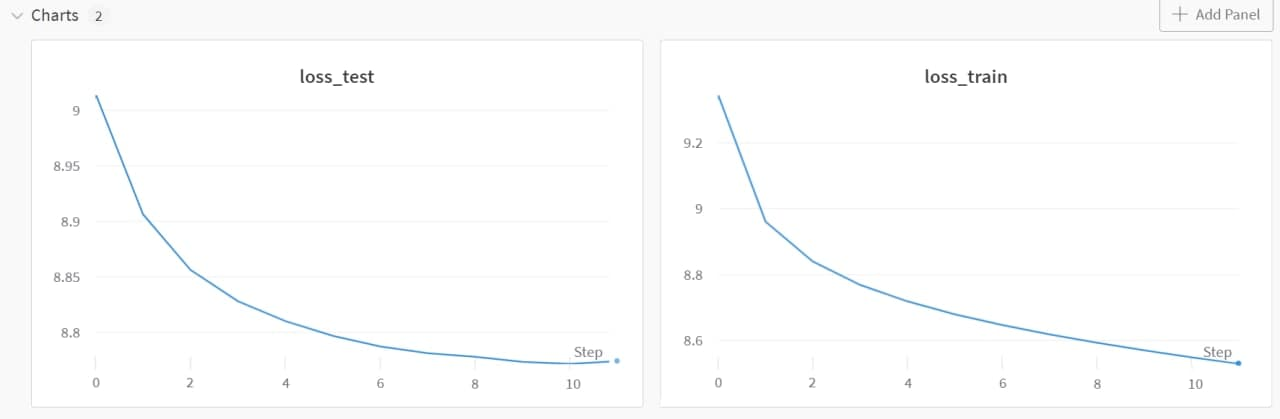

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Сначала я попробовала с двумя слоями, но было маловато. Стала обучаться с четырьмя слоями. Конкретные значения я не выписывала, но бывало, что нейросеть переобучалась, тогда я уменьшала число нейронов.

Было предположение, что, если я отлогарифмирую данные, будет лучше (мне показалось, что столбчатая диаграмма данных выглядит как экспонента, и каким-то образом это могло бы помочь). Но стало хуже. 

Добавляла дропаут, но тоже не помогало. Дропаут и нормировка весов вместе тоже не подошли. Потом попробовала увеличить lr, но отнормировать веса (показалось, что тогда большой шаг градиентного спуска компенсируется тем, что сильно не смогут скакать веса). И так правда получилось! По тысячным методом проб подобрала значения, при которых результат достиг 8.77. Тогда я немножко увеличивала число нейронов и вместе с тем регулировала lr и нормировку весов.

Батчей я сначала пробовала 2^8, но по каким-то причинам решила попробовать 300. Пробовала 512 и 500, но становилось хуже. Поэтому решила остановиться на 300 и особо не меняла.

Пробовала добавлять четвертый слой, но успехов тоже не приносило. Поэтому вернулась к трем слоям.

Еще очень много всякого было, что никаких результатов приличных не давало, поэтому не фиксировала.

С нейронами (90, 125), (125, 100), (100, 1) и lr 0.0006 получилось 8.78 и казалось, что лучше уже невозможно))